In [1]:
from IPython import get_ipython
import warnings
warnings.filterwarnings("ignore")
ipython = get_ipython()
ipython.magic("sx wget https://www.dropbox.com/s/80yl6pxjx7usk4p/ISB_PyTorch_Tutorial.zip") 
!unzip -q ISB_PyTorch_Tutorial.zip
!mv ISB_PyTorch_Tutorial/* .


In [2]:
import torch
import random
import numpy as np


torch.use_deterministic_algorithms(False)

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import os
import re
import warnings

warnings.filterwarnings("ignore")

import pandas as pd

from gensim.models import KeyedVectors

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score, roc_curve, auc, confusion_matrix

%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns

In [3]:
"""Params for training & evaluation
dataFileName: TAB separated file having reviews and ratings
embeddingDim: Size of Word embeddings. We'll use pretrained FastText Word Embeddings - https://github.com/facebookresearch/MUSE
"""

embeddingDim = 300     

In [4]:
data_df=pd.read_excel("/content/bio_train_skills_10k.xlsx")
data_df.head(10)

,phrase,Skill
0,ratul arora,0
1,delhi,0
2,blindness,0
3,a degree,2
4,bachelors,2
5,science,1
6,information technology bsc,1
7,a diploma,2
8,information technology level,1
9,auckland institute,0


In [5]:
data_df.dropna(inplace=True)

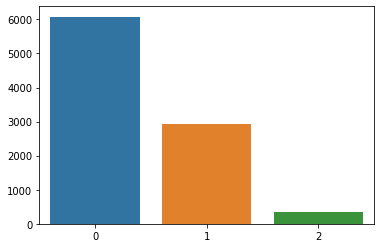

In [6]:
"""
Let's take a quick look at the distribution of different ratings
"""
rating_frequency_count = data_df.Skill.value_counts()
sns.barplot(x=rating_frequency_count.index, y=rating_frequency_count.values)

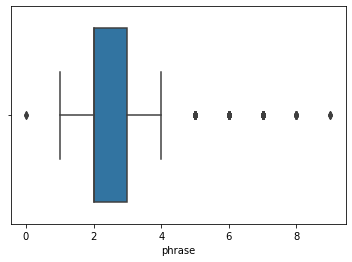

In [7]:
"""
Now let's find out a value for maxlen. For that, we first look at the distribution of review lengths in terms of 
number of words. A box plot is used to visualize this distribution.
"""

re_wordMatcher = re.compile(r'[a-z0-9]+') #Declare regex to extract words
numWords = data_df["phrase"].map(lambda x: len(re_wordMatcher.findall(x.lower())))
g = sns.boxplot(numWords)

In [8]:
"""
The above plot shows that there are few very long reviews (black dots on the right) but most of the reviews are
comparatively shorter than around 250 words. Specifically, let's find the 90th quantile of the review length. 
"""

reviewLen90 = np.quantile(numWords, 0.90)
print("90th quantile of review length:", reviewLen90)

90th quantile of review length: 4.0


In [9]:

"""
Thus, 90% of reviews are of 191 words or shorter. We'll set maxlen close to this.
"""
maxlen = 4

In [10]:
"""
Lets's create training and test datasets by keeping ratio between the positive and negative labels same.
We use sklearn.model_selection.StratifiedKFold setting number of folds (n_splits) = 5, which splits the data into
80% train and 20% test and for 5 folds. But we keep only the first fold for this demo.
"""

skf = StratifiedKFold(n_splits=5)
for trn_idx, tst_idx in skf.split(data_df['phrase'],data_df['Skill']):
    break

train_df, test_df = data_df.iloc[trn_idx], data_df.iloc[tst_idx]

print("Shape of train and test dataframes:", train_df.shape, test_df.shape)

Shape of train and test dataframes: (7476, 2) (1869, 2)


In [11]:
#Read FastText En model. If the file wiki.multi.en.vec' does not exist, download it from 
# https://dl.fbaipublicfiles.com/arrival/vectors/wiki.multi.en.vec
!pip install wget
import wget
word2VecFile = os.path.join(os.curdir, 'wiki.multi.en.vec')

if os.path.exists(word2VecFile):
    print('Word2Vec file has been found and is being loaded...')
else:    
    print('Word2Vec file does not exist and needs to be downloaded')
    url = 'https://dl.fbaipublicfiles.com/arrival/vectors/wiki.multi.en.vec'
    wget.download(url)
    print('Downloading from', url)
en_model = KeyedVectors.load_word2vec_format('wiki.multi.en.vec')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9674 sha256=efb803f2d4bc82bc4b35c3d549192e8c53d50603a3293b82de01fc051de88b9b
  Stored in directory: /root/.cache/pip/wheels/a1/b6/7c/0e63e34eb06634181c63adacca38b79ff8f35c37e3c13e3c02
Successfully built wget
Word2Vec file does not exist and needs to be downloaded


In [12]:
"""
Now let us create a numpy array containing the word vectors. Later this numpy array will be used for initilaizing 
the embedding layer in the model.
"""

vocab = list(en_model.vocab.keys())
print("Vocab size in pretrained model:", len(vocab))

# check if the word 'and' is present in the pretrained model
assert "and" in en_model

# check the dimension of the word vectors
assert embeddingDim == len(en_model["and"])

# initialize a numpy matrix which will store the word vectors
# first row is for the padding token
pretrained_weights = np.zeros((1+len(vocab), embeddingDim))

# tqdm just adds a progress bar
for i, token in enumerate(vocab):
    pretrained_weights[i, :] = en_model[token]

# map tokens in the vocab to ids
vocab = dict(zip(vocab, range(1, len(vocab)+1)))

Vocab size in pretrained model: 200000


In [13]:
def reviewText2Features(reviewText):
    """
    Function which takes review text (basically a string!) as input and returns a features matrix X of shape
    (maxlen, embeddingDim). This is done by splitting the review into words and then representing each word by it's
    word vector obtained from the Word2Vec model. Sentences having more than maxlen words are truncated while shorter
    ones are zero-padded by pre-adding all zero vectors.
    """
    X = []
    
    reviewWords = re_wordMatcher.findall(reviewText.lower())
    
    """
    Tokenize the review using the word-matching regex and get its word vector from the pretrained Word2Vec model.
    Words not found in the Word2Vec model are ignored
    """
    for i, word in enumerate(reviewWords):
        if word not in en_model:
            continue
        if i >= maxlen:
            break
        # X.append(en_model[word])
        X.append(vocab[word])
    
    """
    Add zero padding in the begining of the sequence if the number of words is less than maxlen.
    """
    if len(X) < maxlen:
        # zero_padding = [[0.]*embeddingDim]*(maxlen - len(X))
        zero_padding = [0.]*(maxlen - len(X))
        X = zero_padding + X
    
    return X # np.array(X)
        
def row2Features(row):
    """
    Function which takes a datafram row as input and produces features and labels.
    
    Input: row | Type: pandas.core.series.Series
    
    Output: X, y | Type: X - np.ndarray of shape (maxlen, embeddingDim) & y - int where Positive = 0 & Negative = 1
    """    
    
    X = reviewText2Features(row["phrase"])
    y = row["Skill"]
        
    return X, y

In [14]:
"""
Now apply the above function on a sample row
"""
sampleRow = data_df.iloc[0]
reviewWords = re_wordMatcher.findall(sampleRow["phrase"].lower())
print("Review:", sampleRow["phrase"])
print("Rating:", sampleRow["Skill"])
print("Review words:", reviewWords)

Review: ratul arora
Rating: 0
Review words: ['ratul', 'arora']


In [15]:
"""
Give the sample row to the function row2Features
"""
X, y = row2Features(sampleRow)
print("Dimension of X:", len(X))
print("Label y:", y)

Dimension of X: 4
Label y: 0


In [16]:
def shuffleArray(X, y):
    idx = np.arange(X.shape[0])
    np.random.shuffle(idx)
    X = X[idx, :]
    y = y[idx]
    return X, y

def generateModelReadyData(data, batchSize = 128, shuffle=False):
    """
    Generator function which generates features and labels in batches
    
    Input:
    data - DataFrame where each row has review and sentiment
    batchSize - No. of rows for which features will be created and returned in a batch.
    Note: This is useful for running mini-batch Gradient Descent optimization when the dataset is large.
    
    Output:
    X - 3D np.ndarray of shape (batchSize, maxlen, embeddingDim)
    y - 1D np. array of shape (batchSize,)        
    """
    
    while(True):
        X = []
        y = []
        for _, row in data.iterrows():
            """Generate features and label for this row"""
            X_, y_ = row2Features(row)

            """Keep accumulating the row-wise features"""
            X.append(X_)
            y.append(y_)   

            """If number of rows processed is greater than batchSize yield the batch and trim down X & y
            Note: This way we avoid running into memory issues by not bloating X and y bigger and bigger
            """
            if len(X) > batchSize:
                temp_X, temp_y = np.array(X[:batchSize]), np.array(y[:batchSize])
                if shuffle:
                    temp_X, temp_y = shuffleArray(temp_X, temp_y)
                
                X, y = X[batchSize:], y[batchSize:]                    
                yield temp_X, temp_y

        """Yield the remaining few rows when number of rows in data isn't a mutiple of batchSize"""
        if len(X) > 0:
            temp_X, temp_y = np.array(X), np.array(y)
            if shuffle:
                temp_X, temp_y = shuffleArray(temp_X, temp_y)
            
            yield temp_X, temp_y

In [17]:
"""Let's test the generator function for few batches"""
numBatches = 0
for i, (X, y) in enumerate(generateModelReadyData(data_df, batchSize=128, shuffle=True)):
    if numBatches >= 3:
        break
    
    else:
        print("Batch:", i)
        assert X.shape == (128, maxlen)
        assert y.shape == (128,)
        print("Shape of X & y matches expected values")
    numBatches += 1

Batch: 0
Shape of X & y matches expected values
Batch: 1
Shape of X & y matches expected values
Batch: 2
Shape of X & y matches expected values


In [18]:
# torch.cuda.is_available() checks and returns a Boolean True if a GPU is available, else it'll return False
is_cuda = torch.cuda.is_available()

# If we have a GPU available, we'll set our device to GPU. We'll use this device variable later in our code.
if is_cuda:
    print("cuda available")
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

cuda available


In [19]:
"""
Set random number seed using torch.manual_seed to make sure the same seed is used
by the Pytorch backend and hence ensure repeatable results
"""
#Seed 1
#torch.manual_seed(500)
#random.seed(400)
#np.random.seed(0)

#Seed 2
#torch.manual_seed(600)
#random.seed(450)
#np.random.seed(10)

#Seed 3
torch.manual_seed(700)
random.seed(500)
np.random.seed(20)

In [20]:
class SentimentNet(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, vocab_size, pretrained_weights):
        super(SentimentNet, self).__init__()
        
        self.embedding=nn.Embedding(vocab_size, embedding_dim)
        self.embedding.weight.data.copy_(torch.from_numpy(pretrained_weights))
        
        """
        Adding a dropout layer to force some of the feature values to zero.
        Note: Dropout is a regularization technique which sets the activation of few randomly chosen neurons of
        a hidden layer to zero. It can also be applied to the input layer where some of the input features are set to zero.
        For more details refer http://jmlr.org/papers/v15/srivastava14a.html
        """
        self.sentInputDropout = nn.Dropout(0.2)
        
        """
        Now let's stack a couple of bidirectional RNNs to process the input sequence and extract features
        """
        self.biLSTM1 = nn.LSTM(embedding_dim, hidden_dim[0], bidirectional=True, batch_first=True)
        self.biLSTMDropOut = nn.Dropout(0.2)
        self.dense1 = nn.Linear(2*hidden_dim[0], 128)
        self.tanh1 = nn.Tanh()
        self.dropout1 = nn.Dropout(0.2)

        self.dense2 = nn.Linear(128, 64)
        self.tanh2 = nn.Tanh()
        self.dropout2 = nn.Dropout(0.2)

        self.dense3 = nn.Linear(64, 32)
        self.tanh3 = nn.Tanh()
        self.dropout3 = nn.Dropout(0.2)


        self.outputLayer = nn.Linear(32, 3)
        #self.softmax = nn.Softmax()

        
    def forward(self, x):
        
        batch_len = x.shape[0]
        out = self.embedding(x)
        out = self.sentInputDropout(out)
        out, hidden = self.biLSTM1(out)
        out = self.biLSTMDropOut(out)

        out = self.dense1(out)
        out = self.tanh1(out)
        out = self.dropout1(out)

        out = self.dense2(out)
        out = self.tanh2(out)
        out = self.dropout2(out)

        out = self.dense3(out)
        out = self.tanh3(out)
        out = self.dropout3(out)

        out = self.outputLayer(out)
        #out = self.softmax(out)
        out = out[:,-1]
        return out    

In [21]:
model = SentimentNet(embeddingDim, [256], 1+len(vocab), pretrained_weights)
model.to(device)

SentimentNet(
  (embedding): Embedding(200001, 300)
  (sentInputDropout): Dropout(p=0.2, inplace=False)
  (biLSTM1): LSTM(300, 256, batch_first=True, bidirectional=True)
  (biLSTMDropOut): Dropout(p=0.2, inplace=False)
  (dense1): Linear(in_features=512, out_features=128, bias=True)
  (tanh1): Tanh()
  (dropout1): Dropout(p=0.2, inplace=False)
  (dense2): Linear(in_features=128, out_features=64, bias=True)
  (tanh2): Tanh()
  (dropout2): Dropout(p=0.2, inplace=False)
  (dense3): Linear(in_features=64, out_features=32, bias=True)
  (tanh3): Tanh()
  (dropout3): Dropout(p=0.2, inplace=False)
  (outputLayer): Linear(in_features=32, out_features=3, bias=True)
)

In [22]:
train_df.Skill.value_counts()

0    4862
1    2333
2     281
Name: Skill, dtype: int64

In [23]:
w1=len(train_df[train_df['Skill']==0])/len(train_df)
cw1=1-w1

In [24]:
w2=len(train_df[train_df['Skill']==1])/len(train_df)
cw2=1-w2

In [25]:
w3=len(train_df[train_df['Skill']==2])/len(train_df)
cw3=1-w3

test=[cw1,cw2,cw3]
type(test)

list

In [26]:
weights=torch.tensor(test)
weights.cuda()

tensor([0.3497, 0.6879, 0.9624], device='cuda:0')

In [27]:
lr=0.00079999
criterion = nn.CrossEntropyLoss(weight=weights).cuda()
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)


In [28]:
epochs = 10
counter = 0
print_every = 500
clip = 5
valid_loss_min = np.Inf
#gamma=0.9

model = model.float()
model.train()
for i in range(epochs):
    print("Epoch:", i+1)
    #scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=gamma-(0.001/((epochs+1)-i)))
    #scheduler.step()
    #lr=optimizer.param_groups[0]["lr"]
    print(lr)
    print("Running a pass over the training data...")
    for j, (inputs, labels) in enumerate(generateModelReadyData(train_df, batchSize=128, shuffle=True)):
        if j >= np.ceil(train_df.shape[0]/128):
            break
        
    #for inputs, labels in train_loader:
        counter += 1
        inputs, labels = torch.from_numpy(inputs), torch.from_numpy(labels)
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        output = model(inputs.long())
        loss = criterion(output, labels.type(torch.LongTensor).to(device))
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()        
        if (j+1) % 100 == 0:
            print("Batches completed:", j+1)
    
    print("Batches completed:", j+1)
    val_losses = []
    model.eval()
    print("Running a pass over the test data...")
    for k, (inp, lab) in enumerate(generateModelReadyData(test_df, batchSize=128, shuffle=False)):
        if k >= np.ceil(test_df.shape[0]/128):
            break
        inp, lab = torch.from_numpy(inp), torch.from_numpy(lab)
        inp, lab = inp.to(device), lab.to(device)
        out = model(inp.long())
        val_loss = criterion(out.squeeze(), lab.type(torch.LongTensor).to(device))
        val_losses.append(val_loss.item())
        if (k+1) % 100 == 0:
            print("Batches completed:", k+1)
    
    print("Batches completed:", k+1)

    model.train()
    print("Epoch: {}/{}...".format(i+1, epochs),
          "Step: {}...".format(counter),
          "Loss: {:.6f}...".format(loss.item()),
          "Val Loss: {:.6f}".format(np.mean(val_losses)))
    if np.mean(val_losses) <= valid_loss_min:
        torch.save(model.state_dict(), './state_dict13.pt')
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min,np.mean(val_losses)))
        valid_loss_min = np.mean(val_losses)

Epoch: 1
0.00079999
Running a pass over the training data...
Batches completed: 60
Running a pass over the test data...
Batches completed: 16
Epoch: 1/10... Step: 59... Loss: 0.877303... Val Loss: 0.866702
Validation loss decreased (inf --> 0.866702).  Saving model ...
Epoch: 2
0.00079999
Running a pass over the training data...
Batches completed: 60
Running a pass over the test data...
Batches completed: 16
Epoch: 2/10... Step: 118... Loss: 0.905012... Val Loss: 0.791815
Validation loss decreased (0.866702 --> 0.791815).  Saving model ...
Epoch: 3
0.00079999
Running a pass over the training data...
Batches completed: 60
Running a pass over the test data...
Batches completed: 16
Epoch: 3/10... Step: 177... Loss: 0.352099... Val Loss: 0.672415
Validation loss decreased (0.791815 --> 0.672415).  Saving model ...
Epoch: 4
0.00079999
Running a pass over the training data...
Batches completed: 60
Running a pass over the test data...
Batches completed: 16
Epoch: 4/10... Step: 236... Loss: 0.

In [29]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [30]:
"""
At this point we can load a pretrained model which was trained for 5 epochs and make predictions using it.
Uncomment and run the below line to load the pretrained model
"""
model.load_state_dict(torch.load('/content/drive/MyDrive/state_dict10.pt'))
model.to(device)

SentimentNet(
  (embedding): Embedding(200001, 300)
  (sentInputDropout): Dropout(p=0.2, inplace=False)
  (biLSTM1): LSTM(300, 256, batch_first=True, bidirectional=True)
  (biLSTMDropOut): Dropout(p=0.2, inplace=False)
  (dense1): Linear(in_features=512, out_features=128, bias=True)
  (tanh1): Tanh()
  (dropout1): Dropout(p=0.2, inplace=False)
  (dense2): Linear(in_features=128, out_features=64, bias=True)
  (tanh2): Tanh()
  (dropout2): Dropout(p=0.2, inplace=False)
  (dense3): Linear(in_features=64, out_features=32, bias=True)
  (tanh3): Tanh()
  (dropout3): Dropout(p=0.2, inplace=False)
  (outputLayer): Linear(in_features=32, out_features=3, bias=True)
)

In [31]:
test_losses = []
num_correct = 0
pred_proba = []
actual = []
predicted_values=[]

model.eval()
for j, (X_test, y_test) in enumerate(generateModelReadyData(test_df, batchSize=128)):
    if j >= np.ceil(test_df.shape[0]/128):
        break
    
    inputs_test, labels_test = torch.from_numpy(X_test), torch.from_numpy(y_test)
    inputs_test, labels_test = inputs_test.to(device), labels_test.to(device)
    output_test = model(inputs_test.long())
    test_loss = criterion(output_test.squeeze(), labels_test.type(torch.LongTensor).to(device))
    test_losses.append(test_loss.item())
    _, predicted = torch.max(output_test, 1) 
    predicted_values.extend(predicted)
    correct_tensor = predicted.eq(labels_test.long())
    correct = np.squeeze(correct_tensor.cpu().numpy())
    num_correct += np.sum(correct)
    pred_proba.extend(output_test.cpu().squeeze().detach().numpy())
    actual.extend(y_test)
    
    if (j+1) % 100 == 0:
        print("Batches completed:", j+1)

print("Batches completed:", j+1)

print("Test loss: {:.3f}".format(np.mean(test_losses)))
test_acc = num_correct/len(test_df)
print("Test accuracy: {:.3f}%".format(test_acc*100))

Batches completed: 16
Test loss: 0.538
Test accuracy: 87.480%


In [32]:
x=torch.tensor([2.2186403 , -0.42418113, -2.6695063])
y=torch.nn.Softmax()
op=y(x)

op

tensor([0.9270, 0.0660, 0.0070])

In [33]:
output=y(torch.tensor(pred_proba))
output

tensor([[0.9497, 0.0387, 0.0116],
        [0.9895, 0.0088, 0.0017],
        [0.9895, 0.0088, 0.0017],
        ...,
        [0.0013, 0.0010, 0.9976],
        [0.0013, 0.0010, 0.9976],
        [0.0013, 0.0010, 0.9976]])

In [34]:
print("Area under ROC:", roc_auc_score(actual,output,multi_class="ovo",average='weighted'))

Area under ROC: 0.9364577919612129


In [35]:
test_predicted=[]
for i in predicted_values:
  z=i.cpu().numpy()
  test_predicted.append(int(z))

In [36]:
from sklearn import metrics
print("Model Precision on Test Data")
print(metrics.classification_report(actual, test_predicted)) # 91 82 78


Model Precision on Test Data
              precision    recall  f1-score   support

           0       0.91      0.90      0.91      1216
           1       0.81      0.83      0.82       583
           2       0.81      0.77      0.79        70

    accuracy                           0.87      1869
   macro avg       0.84      0.83      0.84      1869
weighted avg       0.88      0.87      0.87      1869



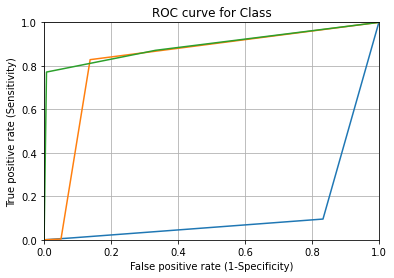

In [43]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

for i in range(3):
  fpr, tpr, thresholds = roc_curve(actual,test_predicted,pos_label=i)
  plt.plot(fpr,tpr)
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.0])
  plt.title('ROC curve for Class')
  plt.xlabel('False positive rate (1-Specificity)')
  plt.ylabel('True positive rate (Sensitivity)')
  plt.grid(True)

In [44]:
!pip install torchmetrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 529 kB 18.1 MB/s 


In [45]:
from torchmetrics import AUROC
auroc = AUROC(num_classes=3,pos_label=2)
auroc(torch.tensor(output),torch.tensor(actual))

tensor(0.9313)

In [46]:
from torchmetrics.classification import MulticlassConfusionMatrix
metric = MulticlassConfusionMatrix(num_classes=3)
metric(torch.tensor(output),torch.tensor(actual))

tensor([[1100,  105,   11],
        [ 100,  481,    2],
        [   9,    7,   54]])

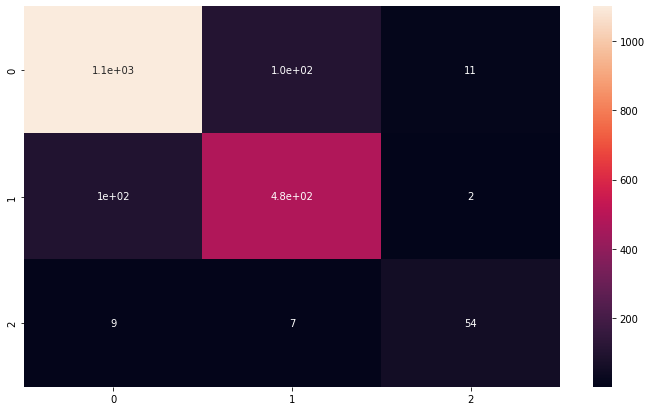

In [47]:
from sklearn.metrics import confusion_matrix
cf_matrix = confusion_matrix(actual, test_predicted)
#df_cm = pd.DataFrame(cf_matrix/np.sum(cf_matrix), index = [i for i in range(3)],
#                     columns = [i for i in range(3)])
plt.figure(figsize = (12,7))
sns.heatmap(cf_matrix, annot=True)
plt.savefig('output.png')

In [48]:

def predictSentiment(reviewText):
    X = reviewText2Features(reviewText)
    X = np.array(X).reshape((1, -1))
    X = torch.from_numpy(X)
    X = X.to(device)
    print(x)
    model.eval()
    pred_proba = model(X.long())
    pred_proba = pred_proba.cpu().squeeze().detach().numpy()
    print(pred_proba)
    return pred_proba

In [49]:
import pandas as pd
import numpy as np 
import re

import matplotlib
import matplotlib.pyplot as plt 
import seaborn as sns
from wordcloud import WordCloud
sns.set()
# # used for better images in medium article
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 22}

matplotlib.rc('font', **font)

from sklearn.feature_extraction.text import CountVectorizer

import nltk
from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer
from nltk.stem.porter import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords

# Required downloads for use with above models
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

In [51]:
df1 = pd.read_excel(r'/content/disability_profiles (1).xlsx')
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1057 entries, 0 to 1056
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  1057 non-null   int64 
 1   name        1057 non-null   object
 2   bio         1057 non-null   object
 3   disability  1057 non-null   object
 4   tags        1057 non-null   object
dtypes: int64(1), object(4)
memory usage: 41.4+ KB


In [52]:
df1.drop(['Unnamed: 0'],inplace=True,axis=1)
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1057 entries, 0 to 1056
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   name        1057 non-null   object
 1   bio         1057 non-null   object
 2   disability  1057 non-null   object
 3   tags        1057 non-null   object
dtypes: object(4)
memory usage: 33.2+ KB


In [53]:
df_bio=df1.bio
df_bio

0       Ratul Arora is from Delhi. He has blindness. H...
1       Aman Verma is from Nalasopara, Maharashtra. He...
2       Sampa Gupta is from Mumbai, Maharashtra. She h...
3       Monu Varma is a 29-year-old visually impaired ...
4       Jayant Singh Raghav believes that the position...
                              ...                        
1052    Resham’s life has not been easy. She thinks th...
1053    Sachin Shetty belongs to the city of dreams_x0...
1054    Chaitanya was_x000D_\nborn with complete blind...
1055    Pulkit_x000D_\nSharma is a fun-loving person w...
1056    Nisha_x000D_\nTayal, a graduate in economics, ...
Name: bio, Length: 1057, dtype: object

In [54]:
def clean_text(raw):
    '''Case specific to be used with pandas apply method'''
    try:
        # remove carriage returns and new lines
        raw = raw.replace('\r', '')
        raw = raw.replace('\n', '')
        
        # brackets appear in all instances
        raw = raw.replace('[', '')
        raw = raw.replace(']', '')
        raw = raw.replace(')', '')
        raw = raw.replace('(', '')
        
        # removing html tags
        clean_html = re.compile('<.*?>')
        clean_text = re.sub(clean_html, ' ', raw)
        
        # removing duplicate whitespace in between words
        clean_text = re.sub(" +", " ", clean_text) 
        
        # stripping first and last white space 
        clean_text = clean_text.strip()
        
        # commas had multiple spaces before and after in each instance
        clean_text = re.sub(" , ", ", ", clean_text) 
        
        # eliminating the extra comma after a period
        clean_text = clean_text.replace('.,', '.')
        
        clean_text = clean_text.replace('_x000D_', ' ')
        clean_text = clean_text.replace("'", '')
        
        clean_text = clean_text.encode('ascii','ignore')
        clean_text = clean_text.decode('ascii','ignore')
        

        
        # using try and except due to Nan in the column
    except:
        clean_text = np.nan
        
    return clean_text

In [55]:
df_bio = df_bio.apply(clean_text)

In [56]:
df_desc = pd.DataFrame(df_bio)
df_desc.dropna(inplace = True)
df_desc.reset_index(inplace = True, drop = True)

In [57]:
def pos_series(keyword):
    '''categorizes after tokenizing words with POS tags'''
    tokens = nltk.word_tokenize(keyword)
    tagged = nltk.pos_tag(tokens)
    return tagged


In [58]:
def grammar(pos_tagged):
  grammar1 = ('''Noun Phrases: {<DT>?<JJ>*<NN|NNS|NNP>+}''')
  chunkParser = nltk.RegexpParser(grammar1)
  tree1 = chunkParser.parse(pos_tagged_arrs)
  grammar2 = ('''NP2: {<IN>?<JJ|NN>*<NNS|NN>}''')
  chunkParser = nltk.RegexpParser(grammar2)
  tree2 = chunkParser.parse(pos_tagged_arrs)
  grammar3 = ('''VS: {<VBG|VBZ|VBP|VBD|VB|VBN><NNS|NN>*}''')
  chunkParser = nltk.RegexpParser(grammar3)
  tree3 = chunkParser.parse(pos_tagged_arrs)
  grammar4 = ('''
    Commas: {<NN|NNS>*<,><NN|NNS>*<,><NN|NNS>*} 
    ''')
  chunkParser = nltk.RegexpParser(grammar4)
  tree4 = chunkParser.parse(pos_tagged_arrs)

  g1_chunks = []
  for subtree in tree1.subtrees(filter=lambda t: t.label() == 'Noun Phrases'):
    # print(subtree)
    g1_chunks.append(subtree)
  g2_chunks = []
  for subtree in tree2.subtrees(filter=lambda t: t.label() == 'NP2'):
    # print(subtree)
    g2_chunks.append(subtree)
  g3_chunks = []
  for subtree in tree3.subtrees(filter=lambda t: t.label() == 'VS'):
    # print(subtree)
    g3_chunks.append(subtree)
  g4_chunks = []
  for subtree in tree4.subtrees(filter=lambda t: t.label() == 'Commas'):
    # print(subtree)
    g4_chunks.append(subtree)

  return g1_chunks,g2_chunks,g3_chunks,g4_chunks

In [59]:
def training_set(chunks):
    '''creates a dataframe that easily parsed with the chunks data '''
    df = pd.DataFrame(chunks)    
    df.fillna('X', inplace = True)
    
    train = []
    for row in df.values:
        phrase = ''
        for tup in row:
            # needs a space at the end for seperation
            phrase += tup[0] + ' '
        phrase = ''.join(phrase)
        # could use padding tages but encoder method will provide during 
        # tokenizing/embeddings; X can replace paddding for now
        train.append( phrase.replace('X', '').strip())

    df['phrase'] = train

    # only returns 10% of each dataframe to be used 
    return df.phrase

In [63]:
dict_new={'name':[],'disability':[],'bio':[],'Skills':[]}
for i in range(len(df1)):
  text1 = df_desc.bio.iloc[i].lower()
  pos_tagged_arrs = pos_series(text1)
  g1_chunks,g2_chunks,g3_chunks,g4_chunks=grammar(pos_tagged_arrs)
  training = pd.concat([training_set(g1_chunks),
                      training_set(g2_chunks), 
                      training_set(g3_chunks),training_set(g4_chunks)], 
                        ignore_index = True )
  skills=[]
  for j in training:
    output=y(torch.tensor(predictSentiment(j)))
    if int(output.argmax().numpy())==1:
         j=clean_text(j)
         j=j.replace(", ","")
         j=j.replace(" ,","")
         skills.append(j)

  dict_new['name'].append(df1['name'].iloc[i])
  dict_new['disability'].append(df1['disability'].iloc[i])
  dict_new['bio'].append(text1)
  dict_new['Skills'].append(skills)

  

Streaming output truncated to the last 5000 lines.
tensor([ 2.2186, -0.4242, -2.6695])
[ 0.2608318 -2.6973214 -3.9270234]
tensor([ 2.2186, -0.4242, -2.6695])
[ 1.926097  -2.7917008 -4.4508176]
tensor([ 2.2186, -0.4242, -2.6695])
[-1.0445979 -1.96118   -3.9156122]
tensor([ 2.2186, -0.4242, -2.6695])
[-2.1345084  3.5525963 -2.6049423]
tensor([ 2.2186, -0.4242, -2.6695])
[ 1.926097  -2.7917008 -4.4508176]
tensor([ 2.2186, -0.4242, -2.6695])
[ 1.926097  -2.7917008 -4.4508176]
tensor([ 2.2186, -0.4242, -2.6695])
[ 1.926097  -2.7917008 -4.4508176]
tensor([ 2.2186, -0.4242, -2.6695])
[ 1.926097  -2.7917008 -4.4508176]
tensor([ 2.2186, -0.4242, -2.6695])
[-2.1362271  3.556462  -2.6903882]
tensor([ 2.2186, -0.4242, -2.6695])
[ 1.926097  -2.7917008 -4.4508176]
tensor([ 2.2186, -0.4242, -2.6695])
[ 1.9260969 -2.7917008 -4.4508176]
tensor([ 2.2186, -0.4242, -2.6695])
[ 1.926097  -2.7917008 -4.4508176]
tensor([ 2.2186, -0.4242, -2.6695])
[-2.1348312  3.553317  -2.6208572]
tensor([ 2.2186, -0.4242, 

In [64]:
newDF=pd.DataFrame(dict_new)
newDF

,name,disability,bio,Skills
0,Ratul Arora,Blindness,ratul arora is from delhi. he has blindness. h...,"[the accessibility, domain, a test engineering..."
1,Aman Verma,Low Vision,"aman verma is from nalasopara, maharashtra. he...","[aman verma, an accessibility tester, an assis..."
2,Sampa Gupta,Blindness,"sampa gupta is from mumbai, maharashtra. she h...","[a certified dhs, tester, accessibility specia..."
3,Monu Varma,Blindness,monu varma is a 29-year-old visually impaired ...,"[computer applications, hcl technologies, brea..."
4,Jayant Singh Raghav,Blindness,jayant singh raghav believes that the position...,"[time management, team leadership, a strong co..."
...,...,...,...,...
1052,Resham Talwar,Blindness,reshams life has not been easy. she thinks tha...,"[braille, a born-to-be voice-over artist, an a..."
1053,Sachin J Shetty,Muscular Dystrophy,sachin shetty belongs to the city of dreams an...,"[stories, a good listener, digital content, ne..."
1054,Chaitanya Purushottam Kayande,Blindness,chaitanya was born with complete blindness and...,"[a tourist guide, co-curricular skills, mimicr..."
1055,Pulkit Sharma,Cerebral Palsy,pulkit sharma is a fun-loving person who is di...,"[a fun-loving person, voiceover, mimicry, funn..."


In [65]:
newDF.to_csv('ProfileToSkills.csv')